There is a correlation between the number of violations committed and the specific zipcode of the establishment.


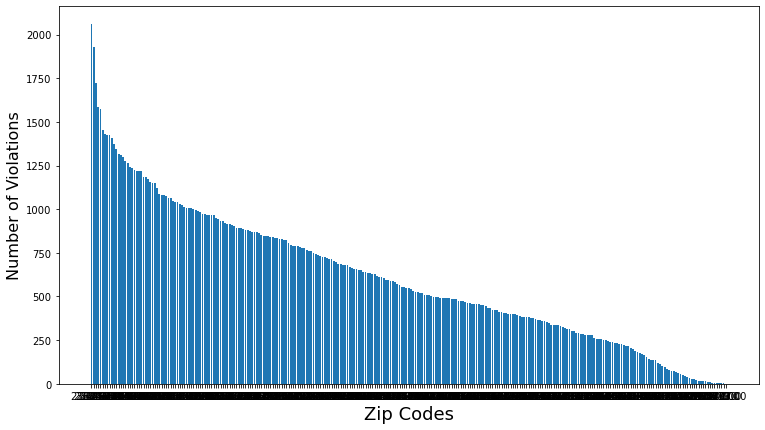

In [17]:
import tkinter as tk
import csv
import json
from tkinter import filedialog as fd
from tkinter import messagebox
from tkinter import ttk
from tkinter import END
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.figure import Figure 
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg,NavigationToolbar2Tk) 

#upload csv files
def get_csv(file_entry):
    global inspections
    global inventory
    global violations
    file_path = fd.askopenfilename(title = "Select file",filetypes = 
                                   (("CSV Files","*.csv"),))
    file = open(file_path, encoding='utf-8-sig')
    if "Inspections" in file_path:
        inspections = pd.read_csv(file)
    if "Inventory" in file_path:
        inventory = pd.read_csv(file)
    if "Violations" in file_path:
        violations  = pd.read_csv(file)
    file_entry.delete(0,END)
    file_entry.insert(0,file_path)

 #convert csv file to json
def convertJson():
    inspections.to_json("Inspections.json")      
    inventory.to_json("Inventory.json")
    violations.to_json("Violations.json")
    mergeData(inspections, inventory, violations)
    messagebox.showinfo("Attention", "CSV files converted to JSON files and data merged.")
    
#merge data set to make cleaning easier
def mergeData(csv1, csv2, csv3):
    global merged_CSV
    insp = csv1
    inv = csv2
    vio= csv3
    cols_to_use=inv.columns.difference(insp.columns)
    insp_inv= pd.merge(insp, inv[cols_to_use], left_index=True, 
                   right_index=True, how='outer')
    cols_to_use2=vio.columns.difference(insp_inv.columns)
    merged_CSV = pd.merge(insp_inv, vio[cols_to_use2], left_index=True, 
                      right_index=True, how='outer')
    merged_CSV.to_csv("merged_data.csv", index=False, sep=',')
    
#function to remove inactive seats
def removeInactive():
    global merged_CSV
    indexInactive = merged_CSV[merged_CSV["PROGRAM STATUS"] == "INACTIVE"].index
    merged_CSV_temp = merged_CSV.drop(indexInactive, inplace=False)
    
    merged_CSV = merged_CSV_temp
    messagebox.showinfo("Attention", "Establishments with inactive programs removed.")
    merged_CSV.to_csv("merged_data.csv", index=False, sep=',')
    
#function to generate seating column
def extractSeating():
    global merged_CSV
    merged_CSV["Seating Type"] = merged_CSV["PE DESCRIPTION"].str.extract('(\(.+\))', expand=True)
    merged_CSV["PE DESCRIPTION"] = merged_CSV["PE DESCRIPTION"].str.replace("(\s\(.+\)\s)", " ", regex=True)
    messagebox.showinfo("Attention", "Seating Arrangements extracted into new column.")  
    merged_CSV.to_csv("merged_data.csv", index=False, sep=',')
    
#extract year of inspection for calculating mean median mode
def extractYear():
    global merged_CSV
    merged_CSV["Year"] = merged_CSV["ACTIVITY DATE"].str.split("/").str[2]
    messagebox.showinfo("Attention", "Year of Inspection Extracted into New Column.")
    merged_CSV.to_csv("merged_data.csv", index=False, sep=',')
    
#function for working out mean
def mean(dfmean, group):
    pd.set_option('display.max_rows', None)
    mean_by_year = dfmean.groupby(['Year', group])['SCORE'].mean()
    return mean_by_year

#function for working out median
def median(dfmedian, group):
    pd.set_option('display.max_rows', None)
    median_by_year = dfmedian.groupby(['Year', group])['SCORE'].median()
    return median_by_year
    
#function for working out mode
def mode(dfmode, group):
    pd.set_option('display.max_rows', None)
    mode_by_year = dfmode.groupby(['Year', group])['SCORE'].agg(lambda x:x.value_counts().index[0])
    return mode_by_year

#displays graph of types of violation per establishment
def displayEstablishVio(merged_data):
    global fig
    merged_data["Violation Number"] = merged_data["VIOLATION DESCRIPTION"].str.extract('(\d+)', expand=True)
    vioNo = merged_data[["Violation Number", "FACILITY NAME"]]
    viofreq = vioNo['Violation Number'].value_counts()
    fig = plt.figure(figsize=(20,8))
    plt.bar(viofreq.index.values, viofreq.values)
    plt.xlabel('Violation Number', fontsize=18)
    plt.ylabel('Number of Violations', fontsize=16)
    return fig

#displays graph of number of violations and zipcode
def displayZipCodeVio(merged_data):
    global fig
    global zipvio
    zipvio = merged_data['Zip Codes'].value_counts()
    fig = plt.figure(figsize=(24,8))
    xaxis = list(map(str, zipvio.index.values))
    plt.bar(xaxis, zipvio.values)
    plt.xlabel('Zip Codes', fontsize=18)
    plt.ylabel('Number of Violations', fontsize=16)
    zipCodeVioCorrelation()
    return fig
    
#works out whether zipcode and number of violations are correlated
def zipCodeVioCorrelation():
    col1=pd.Series(zipvio.index.values)
    col2=pd.Series(zipvio.values)
    correlation = col1.corr(col2)
    if correlation >7.5:
        print("There is a strong correlation between the number of violations committed and the specific zipcode of the establishment.")
    elif correlation <6.5:
        print("There is a correlation between the number of violations committed and the specific zipcode of the establishment.")
    else:
        print("There is not a correlation between the number of violations committed and the specific zipcode of the establishment.")

        #function to display pop up window for mean median mode analysis
def clicker(function, title):
    global pop
    pop = tk.Toplevel(root)
    pop.title(title)
    pop.geometry("800x400")
    pop_label = tk.Label(pop, text=function)
    pop_label.grid(row=0, column=0)
    
#function to display window for graphs in data analysis
def graphClicker(function, title):
    global pop
    pop = tk.Toplevel(root)
    pop.title(title)
    pop.geometry("900x500")
    canvas = FigureCanvasTkAgg(fig, 
                               master = pop)   
    canvas.draw()
    canvas.get_tk_widget().pack() 
    toolbar = NavigationToolbar2Tk(canvas, 
                                   pop) 
    toolbar.update() 
    canvas.get_tk_widget().pack() 
    
class Program:
    def __init__(self):
        self.root = root
        self.frame = tk.Frame(self.root)
        
        #widgets from csv uploading
        entry_csv1=tk.Entry(self.frame, text="", width=70)
        entry_csv1.grid(row=0, column=1, sticky="w")

        entry_csv2=tk.Entry(self.frame, text="", width=70)
        entry_csv2.grid(row=1, column=1, sticky="w")

        entry_csv3=tk.Entry(self.frame, text="", width=70)
        entry_csv3.grid(row=2, column=1, sticky="w")
        
        self.csvlabel1 = tk.Label(self.frame, text="Input Inspections")
        self.csvlabel1.grid(row=0, column=0 ,sticky="e")
        
        self.csvbutton1 = tk.Button(self.frame, text="Choose CSV", width=15, command=lambda:get_csv(entry_csv1))
        self.csvbutton1.grid(row=0, column=2, sticky="w")
        
        self.csvlabel2 = tk.Label(self.frame, text="Input Inventory")
        self.csvlabel2.grid(row=1, column=0 ,sticky="e")
        
        self.csvbutton2 = tk.Button(self.frame, text="Choose CSV", width=15, command=lambda:get_csv(entry_csv2))
        self.csvbutton2.grid(row=1, column=2, sticky="w")
        
        self.csvlabel3 = tk.Label(self.frame, text="Input Violations")
        self.csvlabel3.grid(row=2, column=0 ,sticky="e")
        
        self.csvbutton3 = tk.Button(self.frame, text="Choose CSV", width=15, command=lambda:get_csv(entry_csv3))
        self.csvbutton3.grid(row=2, column=2, sticky="w")
        
        #widgets for data cleaning
        self.topLabel=tk.Label(self.frame, text="Click the boxes in order to clean and display your data.")
        self.topLabel.grid(row=4, column=0, columnspan=2, sticky='w')

        self.createJsonButton = tk.Button(self.frame, text="Create Json files", command=convertJson)
        self.createJsonButton.grid(row=5,column=0, columnspan=2, sticky='w')

        self.removeButton = tk.Button(self.frame, text="Remove Inactive Programs", command=removeInactive)
        self.removeButton.grid(row=6, column=0, columnspan=2, sticky='w')

        self.seatingButton = tk.Button(self.frame, text="Generate Vendor Seating Information", command=extractSeating)
        self.seatingButton.grid(row=7, column=0, columnspan=2, sticky='w')
        
        self.dateButton = tk.Button(self.frame, text="Extract Year of Inspection", command=extractYear)
        self.dateButton.grid(row=8, column=0, columnspan=2, sticky='w')
        
        #widgets for data analysis
        meanZipButton = tk.Button(self.frame, text="Mean inspection score per year per zip code", 
                                  command=lambda:clicker(mean(merged_CSV, 'Zip Codes'), 
                                                         "Mean Inspection Score Per Year by Zip Code"))
        meanZipButton.grid(row=9, column=0, columnspan=2, sticky='w')
        meanSeatButton = tk.Button(self.frame, text="Mean inspection score per year per seating arrangement", 
                                   command=lambda: clicker(mean(merged_CSV, 'Seating Type'), 
                                                           "Mean Inspection Score Per Year by Seating Type"))
        meanZipButton.grid(row=9, column=0, columnspan=2, sticky='w')
        meanSeatButton.grid(row=10, column=0, columnspan=2, sticky='w')

        medianZipButton = tk.Button(self.frame, text="Median inspection score per year per zip code", 
                                    command=lambda:clicker(median(merged_CSV, 'Zip Codes'), 
                                                           "Median Inspection Score per Year by Zip Code"))
        medianZipButton.grid(row=11, column=0, columnspan=2, sticky='w')
        medianSeatButton = tk.Button(self.frame, text="Median inspection score per year per seating arrangement", 
                                     command=lambda:clicker(median(merged_CSV, 'Seating Type'), 
                                                            "Median Inspection Score Per Year by Seating Type"))
        medianSeatButton.grid(row=12, column=0, columnspan=2, sticky='w')

        modeZipButton = tk.Button(self.frame, text="Mode inspection score per year per zip code", 
                                  command=lambda:clicker(mode(merged_CSV, 'Zip Codes'), 
                                                         "Mode Inspection Score per Year by Zip Code"))
        modeZipButton.grid(row=13, column=0, columnspan=2, sticky='w')
        modeSeatButton = tk.Button(self.frame, text="Mode inspection score per year per seating arrangement", 
                                   command=lambda:clicker(mode(merged_CSV, 'Seating Type'), 
                                                          "Mode Inspection Score Per Year by Seating Type"))
        modeSeatButton.grid(row=14, column=0, columnspan=2, sticky='w')

        #button to display graph for violations commited by establishment
        graphButton = tk.Button(self.frame, text="Display Establishment Violations", 
                                command=lambda: graphClicker(displayEstablishVio(merged_CSV),"Establishment Violations"))
        graphButton.grid(row=15, column=0, columnspan=2, sticky='w')  

        #button for correlation visualization between vendor violations and zipcode 
        correlationButton = tk.Button(self.frame, text="Display Zipcode Violations", 
                                      command=lambda:graphClicker(displayZipCodeVio(merged_CSV), "Vendor Violations and Zipcodes"))
        correlationButton.grid(row=16, column=0, columnspan=2, sticky='w')   

        self.quitButton = tk.Button(root, text = 'Quit', width = 25, command = root.destroy)
        
        self.quitButton.pack()
        
        self.frame.pack()
        
root = tk.Tk()
app = Program()
root.mainloop()